In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import re
import http.client
import json
from datetime import datetime


In [2]:
# Read in Dimensions export
df_dimensions = pd.read_csv('Dimensions-Publication-2020-03-06_18-29-37.csv', usecols=['Publication ID', 'DOI', 'Title', 
                                                                            'PubYear','Open Access', 'Publication Type', 
                                                                            'Authors','Country of Research organization', 
                                                                            'Funder', 'Funder Group', 'Funder Country', 
                                                                            'UIDs of supporting grants', 'Supporting Grants', 
                                                                            'Times cited', 'Recent citations', 'RCR', 'FCR', 
                                                                            'Altmetric', 'Source Linkout', 'Dimensions URL', 
                                                                            'FOR (ANZSRC) Categories'])
                                                                            
                                                                            
                                                                            
                                                                            

/Users/kmcdouga/Dropbox (MIT)/Dimensions/citations_and_downloads/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Sort by DOI
df_dimensions.sort_values('DOI', inplace=True)

In [4]:
# Extract the stump of the DOI, which is shared between all chapters of a book.
# We will use this stump of a DOI to group titles and then merge this report with the Zipline report
def slice_doi(row):
    x = re.search("(10.7551/mitpress/[0-9]{4,13}).([0-9]{3}).([0-9]{3})", row['DOI'])
    try:
        return_val = x.group(1)
    except Exception as e:
        print(row['DOI'])
        pass
    return return_val

df_dimensions['DOI_slice'] = df_dimensions.apply(slice_doi, axis=1)

In [5]:
# Yes, we read in a bunch of columns that we're now dropping. Whatever. We might need them for something. 
df_dimensions = df_dimensions[['DOI_slice', 'Times cited', 'Recent citations']]

In [6]:
# Now group each title by DOI stump and add the citations
grouped_dimensions = df_dimensions.groupby(['DOI_slice']).sum()

In [7]:
# Sort of times cited
grouped_dimensions = grouped_dimensions.sort_values('Times cited', ascending=False)
# Reset the index so DOI_slice is now a column
grouped_dimensions.reset_index(inplace=True)

In [8]:
# Let's take a look at the final grouped dimensions report
print('we have {} number of books in the Dimensions report'.format(len(grouped_dimensions)))
print('{} of them have at least one citation'.format(len(grouped_dimensions.loc[grouped_dimensions['Times cited'] != 0])))
# Let's save it to file, just to have it locally
grouped_dimensions.to_csv('grouped_dimensions.csv', index=None)


we have 3064 number of books in the Dimensions report
1404 of them have at least one citation


In [9]:
# Now we need to merge this with a Zipline export to get the Publication ID, 
# which we will then join with the COUNTER report


In [10]:
class Zipit(object):
    """
    Class for connecting and grabbing info from Zipline
    """
    def __init__(self, key):
        self.bearer = key
    
        self.headers = {
            'authorization': "Bearer {}".format(self.bearer),
            'cache-control': "no-cache",
            'postman-token': "54f579dc-993a-f509-94c9-353d23b50209"
            }

        # Make initial call to API to get total pages
        self.conn = http.client.HTTPSConnection("contentapi.direct.mit.edu")
        self.conn2 = http.client.HTTPSConnection("contentapi.direct.mit.edu")

    
    def get_page_count(self):
        self.conn.request("GET", "//books", headers=self.headers)
        res_pages = self.conn.getresponse()
        res_pages

        page_count = int(res_pages.getheader("Pagination-Last"))
        return page_count
    

    
    def pull_dois(self):
        arr = [] # An empty array that will hold each title's info as a list of lists. 
        page_count = self.get_page_count()
        
        
        for p in range(page_count):
            p+=1
            self.conn2.request("GET", "//books/?page={}".format(p), headers=self.headers)
            res = self.conn2.getresponse()
            data = res.read()
            data = json.loads(data)
            
            for i in range(len(data)):
                title_id = data[i]["BookContentItem"]["Book"]['LegacyBookId'] if data[i]["BookContentItem"]["Book"]['LegacyBookId'] else "null"
                title = data[i]["BookContentItem"]["Book"]['Title'] if data[i]["BookContentItem"]["Book"]['Title'] else "null"
                sc_id = data[i]["BookContentItem"]["Book"]['BookId'] if data[i]["BookContentItem"]["Book"]['BookId'] else "null"
                doi = data[i]["BookContentItem"]["Book"]['Doi'] if data[i]["BookContentItem"]["Book"]['Doi'] else "null"
                pub_date = data[i]["BookContentItem"]["Book"]['PublicationDate'] if data[i]["BookContentItem"]["Book"]['PublicationDate'] else "null"

                print('processing page {} of {}'.format(p, page_count))
                arr.append([title_id, title, sc_id, doi, pub_date])
        return arr
    
    
    
    
    
    

### RUN THIS IF YOU WANT TO CREATE A NEW DF FROM THE ZIPLINE API
#### (If you get a NoneType error, you may need to refresh your API key)

In [11]:

# api_key = '' # Saved externally
# z = Zipit(key=)
# all_zipline_data = z.pull_dois()

# # # Convert the list of lists to a dataframe and save to a file in case we need it and don't want to keep hitting the API
# df_zipline = pd.DataFrame(all_zipline_data, columns=['title_id', 'title', 'PublicationID', 'DOI', 'pubdate']) 
# df_zipline.to_csv('all_zipline_titles.csv', index=None) # SAVE TO A LOCAL FILE


### RUN THIS IF YOU WANT TO READ AN EXISTING CSV FILE PULLED FROM THE ZIPLINE API.
#### (If you think new titles have been added, run the above)

In [12]:
df_zipline = pd.read_csv('all_zipline_titles.csv')

In [13]:
# Let's take a look at the final grouped dimensions report
print('we have {} number of books in the Zipline report'.format(len(df_zipline)))
# print('{} of them have at least one citation'.format(len(grouped_dimensions.loc[grouped_dimensions['Times cited'] != 0])))


we have 2790 number of books in the Zipline report


In [14]:
# Now we have to dataframes, the first is pulled from Dimensions, the second from Zipline
# We need to add a new column to the Zipline DF adding the DOI stump.
# That will give us a shared key to merge the two


In [15]:
# df_dimensions.drop_duplicates(inplace=True)

In [16]:
# df_dimensions

In [17]:
df_zipline['DOI_slice'] = df_zipline.apply(slice_doi, axis=1)

In [18]:
df_zipline.sort_values(['DOI']).head()

,title_id,title,PublicationID,DOI,pubdate,DOI_slice
756,10004,Evaluation and Credentialing in Digital Music ...,4035,10.7551/mitpress/10004.001.0001,2014-11-07T00:00:00,10.7551/mitpress/10004
1320,10012,"Log-Linear Models, Extensions, and Applications",4174,10.7551/mitpress/10012.001.0001,2018-11-27T00:00:00,10.7551/mitpress/10012
2776,10014,Writing and Unwriting (Media) Art History<subt...,2286,10.7551/mitpress/10014.001.0001,2015-09-11T00:00:00,10.7551/mitpress/10014
1110,10020,Indecision Points<subtitle>George W. Bush and ...,3433,10.7551/mitpress/10020.001.0001,2014-12-05T00:00:00,10.7551/mitpress/10020
172,10021,Atari Age<subtitle>The Emergence of Video Game...,2282,10.7551/mitpress/10021.001.0001,2017-02-10T00:00:00,10.7551/mitpress/10021


In [19]:
# Merge the Zipline file with the DImensions file. Merge on the DOI Stump. Make it an outer join
# It's an outer join because we want to see highly cited books not on Dimensions and books on Direct 
# That Dimensions did not find or know about. 
dimensions_zipline = pd.merge(df_zipline, grouped_dimensions, how='outer', on='DOI_slice')

# Let's save this locally so we can maybe play around with it in Tableau (Or Excel, depemnding on my level of commitment)
dimensions_zipline.to_csv('dimensions_zipline.csv', index=None)

# What would be cool to look at it is the titles that have a high citation count 
# but are not available on Dimensions. So let's do that now
cited_not_on_direct = dimensions_zipline.loc[dimensions_zipline['Times cited'] >= 20]  # Drop anything with fewer than 20 citations
cited_not_on_direct = cited_not_on_direct[cited_not_on_direct['title_id'].isnull()] #Drop anything with a title_id (not on Dorect therefore)
print('There are {} titles with at least 20 citations that are not on Direct'.format(len(cited_not_on_direct)))
cited_not_on_direct.to_csv('cited_not_on_direct.csv', index=None)


There are 42 titles with at least 20 citations that are not on Direct


In [20]:
# Next, we want to compare citation numbers against COUNTER usage
# To see of there is a large difference between usage and citation. 
# Are people download many copies of a title but not citing it?
# A more interesting queston is whether people are downloading a few copies but the citations are high. 
# The goal is to help narrow in on assesing quality of usage
# It's an extremely rough indicator that should be taken with a grain of salt. 

# We already have a file for COUNTER usage, so let;s just read that in
counter = pd.read_csv('direct_usage_05032020140244.csv')

# Rename the Title ID column so there's a shared key
counter.rename(columns={'IDTitle':'title_id'}, inplace=True)

In [21]:
# Now let's merge the previously merged file with this one. 
# First, drop any titles missing a titleID since those are definitionally not on Direct
print('there are {} titles in Dimensions but not on Direct. we are dropping those titles'.format(dimensions_zipline['title_id'].isna().sum()))
dimensions_zipline = dimensions_zipline[dimensions_zipline['title_id'].notnull()]
print('dimensions_zipline not include {} values.'.format(len(dimensions_zipline)))

# Let's also convert the title id from a float to int
dimensions_zipline['title_id'] = dimensions_zipline['title_id'].astype('int64')


there are 467 titles in Dimensions but not on Direct. we are dropping those titles
dimensions_zipline not include 2790 values.


In [22]:
# Anyway, read in the COUNTER usgae numbers. 
counter_2019 = pd.read_csv('201912_MITP-32_PublisherReports/201912_MITP-32_BookUsage.csv', encoding='latin', usecols=["PublicationID", "YTD_TOTAL"])
counter_current = pd.read_csv('202002_MITP-32_PublisherReports/202002_MITP-32_BookUsage.csv', encoding='latin', usecols=["PublicationID", "YTD_TOTAL"])
counter_combined = pd.merge(counter_2019, counter_current, how='outer', on='PublicationID')

# Rename the YTD cols to distinguish the years
counter_combined.columns=['PublicationID','2019YTD', '2020YTD'] 

# Fill na values with Zero since NA indicates zero usage
counter_combined = counter_combined.fillna(0)

# Add 2019 and 2020 usage
def add_years(row):
    total = row['2019YTD'] + row['2020YTD']
    return total
counter_combined['Total'] = counter_combined.apply(add_years, axis=1)

# Convert the total usage from float to int
counter_combined['Total'] = counter_combined['Total'].astype('int64')


In [35]:
# Merge the zipline file with the counter file add the Title Id, whch we will
# need for the next step, which is merging the counter data with the Dimensions data
x = pd.merge(df_zipline, counter_combined, how='left', on='PublicationID')

# Now merge that with the citation info from dimensions
# merge on title_id and make it an outter merge so we don;t drop any values 
# if there's no usage or no citations. We WANT to see books with high citation counts
# but low usage and what not. 
citations_usage = pd.merge(dimensions_zipline, x, how='outer', on='title_id')

citations_usage = citations_usage[['title_id', 'Times cited', 'Recent citations', 'title_y', 'pubdate_y', 'Total']]

citations_usage.rename(columns={'Total':'Downloads'}, inplace=True)

citations_usage = citations_usage.fillna(0)

# Save localy.
citations_usage.to_csv('citations_usage.csv', index=None)

# sick

In [56]:
# Finally, let's run some basic summary stats 
# to see what the correlation is between usage and citations
corr = citations_usage.corr()
corr

,title_id,Times cited,Recent citations,Downloads
title_id,1.000000,-0.065925,-0.008944,0.193486
Times cited,-0.065925,1.000000,0.881610,-0.023219
Recent citations,-0.008944,0.881610,1.000000,-0.003735
Downloads,0.193486,-0.023219,-0.003735,1.000000


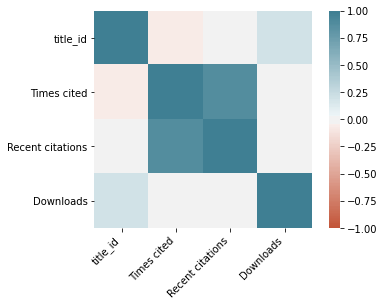

In [57]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [47]:
citations_usage_oa = citations_usage[citations_usage['title_id'].isin(oa_title_ids)]
citations_usage_oa

,title_id,Times cited,Recent citations,title_y,pubdate_y,Downloads
54,9098,56.0,19.0,"Access Contested<subtitle>Security, Identity, ...",2011-09-30T00:00:00,0.0
55,8551,128.0,36.0,Access Controlled<subtitle>The Shaping of Powe...,2010-04-02T00:00:00,10.0
56,7617,123.0,17.0,Access Denied<subtitle>The Practice and Policy...,2008-01-25T00:00:00,3.0
64,10809,0.0,0.0,Actual Causality,2016-08-12T00:00:00,31.0
105,10958,0.0,0.0,Agreement Beyond Phi,2017-03-24T00:00:00,15.0
...,...,...,...,...,...,...
2593,11300,0.0,0.0,Transit-Oriented Displacement or Community Div...,2019-04-09T00:00:00,166.0
2698,9601,0.0,0.0,We Used to Wait<subtitle>Music Videos and Crea...,2014-10-24T00:00:00,14.0
2707,10769,8.0,7.0,"What Do Science, Technology, and Innovation Me...",2017-06-16T00:00:00,28.0
2728,11073,0.0,0.0,When Things Don't Fall Apart<subtitle>Global F...,2018-01-12T00:00:00,16.0


In [59]:
# And now let's run those same numbers on just the OA material
corr_oa = citations_usage_oa.corr()
corr

,title_id,Times cited,Recent citations,Downloads
title_id,1.000000,-0.065925,-0.008944,0.193486
Times cited,-0.065925,1.000000,0.881610,-0.023219
Recent citations,-0.008944,0.881610,1.000000,-0.003735
Downloads,0.193486,-0.023219,-0.003735,1.000000


,title_id,Times cited,Recent citations,Downloads
title_id,1.000000,-0.245018,-0.138434,0.113148
Times cited,-0.245018,1.000000,0.875988,-0.093102
Recent citations,-0.138434,0.875988,1.000000,-0.068332
Downloads,0.113148,-0.093102,-0.068332,1.000000


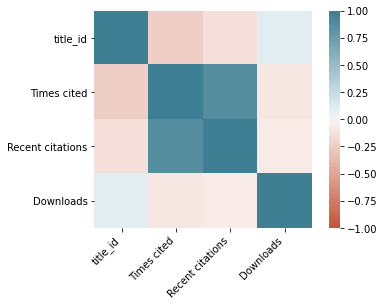

In [60]:
ax = sns.heatmap(
    corr_oa, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [38]:
oa_title_ids = ['6933',
'6933',
'6743',
'6689',
'6689',
'6515',
'5868',
'5638',
'5636',
'5572',
'4196',
'4196',
'3959',
'3589',
'3229',
'3229',
'3206',
'2333',
'2333',
'2260',
'1885',
'1847',
'1847',
'1432',
'1431',
'1429',
'1408',
'1407',
'1406',
'7617',
'7641',
'7728',
'7893',
'7897',
'7898',
'7899',
'7900',
'7901',
'3959',
'8051',
'8179',
'8291',
'8325',
'8402',
'8410',
'8435',
'8474',
'8479',
'8517',
'8518',
'8519',
'8520',
'8551',
'8563',
'8592',
'8601',
'5572',
'8698',
'8755',
'8758',
'8778',
'7641',
'8909',
'8910',
'8929',
'8944',
'9017',
'9040',
'9066',
'9098',
'9133',
'9153',
'9248',
'9286',
'9327',
'9351',
'9382',
'9430',
'9451',
'9457',
'9515',
'9579',
'9580',
'9589',
'9601',
'8051',
'9647',
'9724',
'9777',
'8402',
'9807',
'9817',
'9874',
'9900',
'9949',
'9954',
'9995',
'10002',
'10004',
'10005',
'10086',
'10094',
'8291',
'10116',
'10171',
'10251',
'10259',
'10290',
'9040',
'9451',
'10334',
'10492',
'10524',
'10539',
'10541',
'10580',
'10601',
'10654',
'10678',
'10769',
'9248',
'10809',
'10815',
'10816',
'10834',
'10869',
'10887',
'10890',
'10905',
'10914',
'10935',
'10958',
'10990',
'11008',
'11023',
'11073',
'10005',
'10116',
'8755',
'11087',
'11090',
'11106',
'11130',
'11173',
'11185',
'11209',
'11245',
'11263',
'11273',
'8179',
'11300',
'11304',
'11339',
'11344',
'11363',
'11366',
'11408',
'11418',
'11452',
'11470',
'11480',
'11536',
'11543',
'11555',
'11568',
'11576',
'11582',
'11600',
'11635',
'11649',
'11668',
'11682',
'11701',
'11718',
'11719',
'11739',
'11756',
'11765',
'11771',
'10524',
'11805',
'11832',
'11862',
'11866',
'11868',
'11885',
'11960',
'11969',
'12075',
'12077',
'12093',
'12108',
'11245',
'10678',
'12136',
'12160',
'12200',
'12211',
'12248',
'12255',
'12399',
'12401',
'10809',
'12413',
'12417',
'12437',
'12453',
'12463',
'12486',
'12517',
'12643',
'12686',
'12775',
'12799',
'13382',
'13383',
'13392',
'13482',
'13504',
'13547',
'11582',
'11555',
'13593',
'11756',
'13824']